# Mutual Information in SimClr

In this notebook, we want to demystify what's happening to the encoder in the SimClr  https://arxiv.org/abs/2002.05709  as we train it. We use the same notation as in the paper where, x is an image, h = resnet(x), z = g(h) where g is a NN with one hidden layer. <br>

We take a look at the mutual information <br>
I(x;z) = H(z) -E_x(H(z|x)) <br>

which (according to wikipedia) quantifies the "amount of information" (in units such as shannons, commonly called bits) obtained about one random variable through observing the other random variable. <br>

Since it's difficult to calculate the entropy we approximated it using the upper bound from inequalities <br>
H(u) <= 0.5*log(2pi*e) + 0.5*log(det(cov(u)) <= 0.5*log(2pi*e) + 0.5*log(trace(cov(u))<br>
So we are interested in two quantities, log det of covariance matrix and trace of covariance matrix.


### calculation for h

* for h (or z), we sample B images from the dataset (train or test set) x1,x2,...xB
* apply augmentation to each image
* apply an encoder to calculate h (or z)
* calculate a covariance matrix of h1,h2,...hB , C which is a DxD matrix where D is the dimension of h(or z)

### calculation for h|x

* for h|x (or z|x) we sample B images from the dataset (train or test set) x1,x2,...xB
* for each xi, we generate A images by applying random augmentations xi1, xi2, ... xiA
* apply an encoder to get hi1,hi2, ... hiA and calculate a covariance matrix Ci
* calculate trace or logdet of each Ci
* take an average of trace (or logdet) from C1, C2, ... CB

In [ ]:
import os
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
from configs import get_datasets
from critic import LinearCritic
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from PIL import Image
from models import *
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import math
import seaborn as sns


### config ####
num_workers = 2
batch_size = 512
img_size = 32
temperature = 0.5
dataset = 'cifar10'
CACHED_MEAN_STD = {
        'cifar10': ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        'cifar100': ((0.5071, 0.4865, 0.4409), (0.2009, 0.1984, 0.2023)),
        'stl10': ((0.4409, 0.4279, 0.3868), (0.2309, 0.2262, 0.2237)),
        'imagenet': ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    }

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
##### Transformation #####
def ColourDistortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([rnd_color_jitter, rnd_gray])
    return color_distort


transform_train = transforms.Compose([
        transforms.RandomResizedCrop(img_size, interpolation=Image.BICUBIC),
        transforms.RandomHorizontalFlip(),
        ColourDistortion(s=0.5),
        transforms.ToTensor(),
        transforms.Normalize(*CACHED_MEAN_STD[dataset]),
    ])


# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


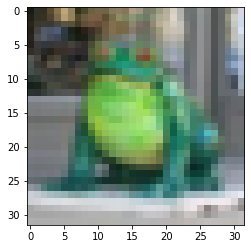

In [3]:
root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
pic = train[19][0]
plt.imshow(pic)

# Code for generate data

In [4]:
##### generate data ######

root = '/data/cifar10/'
train = torchvision.datasets.CIFAR10(root = root, train=True, download=True)
test = torchvision.datasets.CIFAR10(root = root, train = False, download = True)
    
def x_to_xaug(data, sample = 100, index = 0):
    '''
    Input : a list of picture, index of the pic we want, sample = number of sample generate 
    
    Output: list of pictures each have random augmentations on it
    '''
    x = []
    original_pic = data[index][0]
    for i in range(sample):
        transform_pic = transform_train(original_pic)
        x.append(transform_pic)
    return x

def gen_data(B = 500, sample = 100):
    '''
    B = image batch
    num_aug = number of augmented picture for each image 
    
    return x_train, x_test (list) [[pic1_aug1, pic1_aug2, ..., pic1_augA], [pic2_aug1, pic2_aug2, ...], ..., [picB_aug1,....picB_augA]]
    '''
    idx_train = np.random.randint(low = 0, high = len(train), size = B)
    idx__test = np.random.randint(low = 0, high = len(test), size = B)
    #sample augmented image !
    X_train = [x_to_xaug(data = train, sample = sample, index = idx_train[i]) for i in range(B)]
    X_test = [x_to_xaug(data = test, sample = sample, index = idx__test[i]) for i in range(B)]
    
    return X_train, X_test


# get data for x with only one sample for each image 
def gen_data_1pic(B = 100):
    '''
    the main difference between this function and gen_data is that this function return
    a list [[pic1_aug, pic2_aug, ..., picB_aug]] each original picture is selected once
    '''
    train, test = gen_data(B=B, sample = 1)
    X_train1 = [train[i][0] for i in range(len(train))]
    X_test1 = [test[i][0] for i in range(len(test))]
    return [X_train1], [X_test1]


Files already downloaded and verified
Files already downloaded and verified


# Code for calculating h, z, covariance matrix

In [5]:
##### load net, critics Resnet18 checkpoint ######
def get_net(filename):
    '''
    Input: checkpoint filename
    Return: net, critic
     
    '''
    
    net = ResNet18()
    net = net.to(device)

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    #print('==> Loading encoder from checkpoint..')
    resume_from = os.path.join('./checkpoint', filename)
    checkpoint = torch.load(resume_from)
    net.load_state_dict(checkpoint['net'])
    
    #load critics
    critics = LinearCritic(net.representation_dim, temperature=temperature).to(device)
    critics.load_state_dict(checkpoint['critic'])
    
    return net, critics

In [6]:
#calculating h, z from x
def x_to_h(x, net):
    '''
    Input list[tensor] , net
    
    return list[tensor]
    '''
    h = []
    net.eval()
    with torch.no_grad():
        for i in range(len(x)):
            x_i = x[i].unsqueeze(0)
            h_i = net(x_i)
            h.append(h_i)
    return h

def h_to_z(h, critics):
    '''
    Input list[tensor] , critics
    
    return list[tensor]
    '''
    z = []
    critics.eval()
    with torch.no_grad():
        for i in range(len(h)):
            z_i = critics.project(h[i])
            z.append(z_i)
    return z

In [7]:
#calculate covariance matrix from a list of h
def h_to_cov(h):
    '''
    h = list(tensor1, tensor2, ...)
    
    return 512x512 covariance matrix 
    '''
    B = len(h)
    H_torch = torch.stack(h).squeeze(1)
    H_torch_mean = H_torch.mean(dim = 0)
    H_torch_mean = H_torch_mean.repeat(B,1)
    
    H_torch_norm = H_torch- H_torch_mean
    cov_H = 1/(B-1) * torch.matmul(H_torch_norm.transpose(0,1), H_torch_norm)
    
    return cov_H


def cov_to_trace(cov_H):
    '''
    Input covariance tensor
    return trace
    '''
    return cov_H.trace()

def cov_to_logdet(cov_H, buffer = 1):
    '''
    Input covariance tensor
    return logdet of (covariance matrix + buffer* identity)
    '''
    return (cov_H + (torch.eye(cov_H.size()[0])*buffer).to(device)).det().log()

# Code for calculation

In [8]:
def x_to_cov(X, filename):
    '''
    Input: X is a list of list of tensor
        [[tensor11,tensor12,...,], .... [tensorn1,tensorn2, ....]]
        
    filename = checkpoint filename
    Return: a list of covariance matrix
    [cov_tensor1, cov_tensor2, ...., cov_tensorn]
    '''
    net, critics = get_net(filename)
    
    cov_H = []
    cov_Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        cov_h_i = h_to_cov(h_i) # calculate covariance matrix
        cov_z_i = h_to_cov(z_i)
        
        cov_H.append(cov_h_i)
        cov_Z.append(cov_z_i)
        
    return cov_H, cov_Z

def x_to_logdet(X, filename):
    '''
    Input: X is a list of list of tensor
        [[tensor11,tensor12,...,], .... [tensorn1,tensorn2, ....]]
        
    filename = checkpoint filename
    Return: a list of log det of covariance matrix
    [logdet_cov_tensor1, logdet_cov_tensor2, ...., logdet_cov_tensorn]
    '''
    
    net, critics = get_net(filename)
    
    logdet_H = []
    logdet_Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        cov_h_i = h_to_cov(h_i) # calculate covariance matrix
        cov_z_i = h_to_cov(z_i)
        
        logdet_H.append(cov_to_logdet(cov_h_i))
        logdet_Z.append(cov_to_logdet(cov_z_i))
        
        
    return logdet_H, logdet_Z



def x_to_trace(X, filename):
    
    '''
    Input: X is a list of list of tensor
        [[tensor11,tensor12,...,], .... [tensorn1,tensorn2, ....]]
        
    filename = checkpoint filename
    Return: a list of trace of covariance matrix
    [trace_cov_tensor1, trace_cov_tensor2, ...., trace_cov_tensorn] for h and z
    '''
    
    net, critics = get_net(filename)
    
    trace_H = []
    trace_Z = []
    for i in range(len(X)):
        x_i = X[i]  # list of augmented images that come from the same original pic
        h_i = x_to_h(x_i, net)
        z_i = h_to_z(h_i, critics)
        cov_h_i = h_to_cov(h_i) # calculate covariance matrix
        cov_z_i = h_to_cov(z_i)
        
        trace_H.append(cov_to_trace(cov_h_i))
        trace_Z.append(cov_to_trace(cov_z_i))
        
    return trace_H, trace_Z
       
def Batch_x_to_value(X, checkpointfile, mode = 'trace'):
    '''
    Input: X is a list of list of tensor
        [[tensor11,tensor12,...,], .... [tensorn1,tensorn2, ....]]
        
    checkpointfile = a list of checkpointfile name e.g. [resnet18.pth99, resnet18.pth199, .....]
    Return: a dictionary 
    {checkpoint : mean([trace_cov_tensor1, trace_cov_tensor2, .... , trace_cov_tensorn])}
    (trace or logdet depends on mode)
    
    for h and z
    '''
    
    
    if (mode == 'trace'):
        avg_trace_h = {}
        avg_trace_z = {}
        for filename in tqdm(checkpointfile):
            trace_H_i, trace_Z_i = x_to_trace(X, filename)
            avg_trace_H_i = torch.tensor(trace_H_i).mean()
            avg_trace_Z_i = torch.tensor(trace_Z_i).mean()

            avg_trace_h[filename] = avg_trace_H_i
            avg_trace_z[filename] = avg_trace_Z_i

        return avg_trace_h, avg_trace_z
    elif (mode == 'log_det'):
        avg_logdet_h = {}
        avg_logdet_z = {}
        for filename in tqdm(checkpointfile):
            logdet_H_i, logdet_Z_i = x_to_logdet(X, filename)
            avg_logdet_H_i = torch.tensor(logdet_H_i).mean()
            avg_logdet_Z_i = torch.tensor(logdet_Z_i).mean()

            avg_logdet_h[filename] = avg_logdet_H_i
            avg_logdet_z[filename] = avg_logdet_Z_i

        return avg_logdet_h, avg_logdet_z
            

# Plot helper

In [9]:
#plot 2 dict
def my_plot2(train_dict, test_dict, title = 'trace of covariance h|x' , label1 = 'train', label2 = 'test'):
    plt.plot([99+ 100*i for i in range(10)], [train_dict[cp] for cp in checkpointfile], label = label1, color = 'r')
    plt.plot([99+ 100*i for i in range(10)], [test_dict[cp] for cp in checkpointfile], label = label2, color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()
        

#plot 1 dict
def my_plot1(train_dict, title = 'trace of covariance h|x', label1 = 'train'):
    plt.plot([99+ 100*i for i in range(10)], [train_dict[cp] for cp in checkpointfile], label = label1, color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()

#plot list
def my_plot(my_list, title = 'best accuracy each checkpoint', label1 = 'best_acc'):
    plt.plot([99+ 100*i for i in range(10)], [my_list[i] for i in range(10)], label = label1, color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()

# Sanity check !

### plot with different value of B -> converge

In [10]:
#plot log det cov h against B
B_list = [10*i for i in range(1,20)]
logdet_H = []
logdet_Z = []
trace_H = []
trace_Z = []
for B in tqdm(B_list):
    X_train, X_test = gen_data_1pic(B = B)
    logdet_h, logdet_z = x_to_logdet(X_train, 'resnet18_new.pth399')
    trace_h, trace_z = x_to_trace(X_train, 'resnet18_new.pth399')
    
    logdet_H.append(logdet_h[0])
    logdet_Z.append(logdet_z[0])
    
    trace_H.append(trace_h[0])
    trace_Z.append(trace_z[0])
    

100%|██████████| 19/19 [00:31<00:00,  1.68s/it]


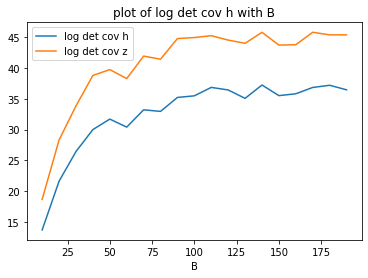

In [11]:
plt.plot(B_list, logdet_H,  label = 'log det cov h')
plt.plot(B_list, logdet_Z,  label = 'log det cov z')
plt.legend()
plt.xlabel('B')
plt.title('plot of log det cov h with B')
plt.show()

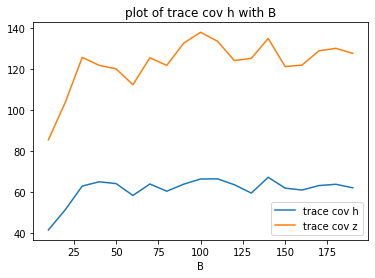

In [12]:
plt.plot(B_list, trace_H,  label = 'trace cov h')
plt.plot(B_list, trace_Z,  label = 'trace cov z')
plt.legend()
plt.xlabel('B')
plt.title('plot of trace cov h with B')
plt.show()

### Check with multivariate normal distribution

In [13]:
multi_norm_dist = torch.distributions.MultivariateNormal(torch.zeros([1, 3]), 
                                                         covariance_matrix = torch.eye(3))

cov_list = []
trace_list = []
logdet_list = []
for i in range(1,50):
    h_test = []
    for j in range(100*i):
        h_test.append(multi_norm_dist.sample().to(device))
    a = h_to_cov(h_test)
    b = cov_to_trace(a)
    c = cov_to_logdet(a, buffer = 0.1)
    cov_list.append(a)
    trace_list.append(b)
    logdet_list.append(c)

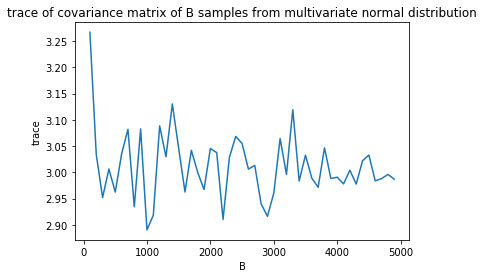

In [14]:
plt.plot([100*i for i in range(1,50)], trace_list)
plt.xlabel('B')
plt.ylabel('trace')
plt.title('trace of covariance matrix of B samples from multivariate normal distribution')
plt.show()

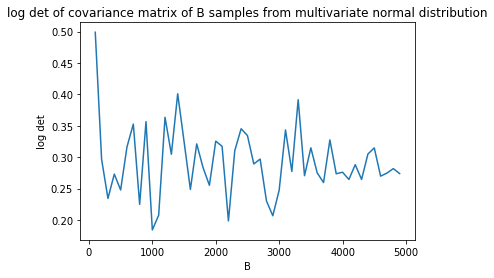

In [15]:
plt.plot([100*i for i in range(1,50)], logdet_list)
plt.xlabel('B')
plt.ylabel('log det')
plt.title('log det of covariance matrix of B samples from multivariate normal distribution')
plt.show()

### check convargence of the matrix

In [16]:
print('B = 100')
print(cov_list[0])

B = 100
tensor([[ 1.0157, -0.0921, -0.0519],
        [-0.0921,  1.0265, -0.0503],
        [-0.0519, -0.0503,  1.2246]], device='cuda:0')


In [17]:
print('B = 2000')
print(cov_list[20])

B = 2000
tensor([[ 1.0201,  0.0439, -0.0056],
        [ 0.0439,  0.9798,  0.0166],
        [-0.0056,  0.0166,  1.0376]], device='cuda:0')


In [18]:
print('B = 4000')
print(cov_list[40])

B = 4000
tensor([[ 1.0036e+00, -3.3429e-02, -5.1746e-03],
        [-3.3429e-02,  9.6728e-01, -9.3824e-04],
        [-5.1746e-03, -9.3824e-04,  1.0071e+00]], device='cuda:0')


### check size h

In [19]:
B = 100
X_train1 , X_test1 = gen_data_1pic(B = B)
net, critics = get_net('resnet18_new.pth99')
H = x_to_h(X_train1[0], net)
Z = h_to_z(H, critics)

# h to covariance, z to covariance
cov_H = h_to_cov(H)
cov_Z = h_to_cov(Z)

In [20]:
cov_H.size()

torch.Size([512, 512])

In [21]:
cov_Z.size()

torch.Size([128, 128])

In [22]:
cov_to_logdet(cov_H)

tensor(75.7499, device='cuda:0')

In [23]:
cov_to_logdet(cov_Z)

tensor(40.2765, device='cuda:0')

### check size h|x 

In [24]:
X_train, X_test = gen_data(B = 20, sample = 10)

In [25]:
cov_H_x, cov_Z_x = x_to_cov(X_train, 'resnet18_new.pth99')

In [26]:
len(cov_H_x)

20

In [27]:
cov_H_x[0].size()

torch.Size([512, 512])

In [28]:
cov_Z_x[0].size()

torch.Size([128, 128])

### correctness check that trace of the resulted covariance is the same as we have from torch.var()

In [29]:
B = 100
X_train1 , X_test1 = gen_data_1pic(B = B)
net, critics = get_net('resnet18_new.pth99')
H = x_to_h(X_train1[0], net)
H_torch = torch.stack(H).squeeze(1)

In [30]:
H_torch.size()

torch.Size([100, 512])

In [31]:
H_torch.var(0).size()

torch.Size([512])

In [32]:
# trace from pytorch
H_torch.var(0).sum(0)

tensor(345.5621, device='cuda:0')

In [33]:
# trace from my function
cov_H = h_to_cov(H)
cov_H.trace()

tensor(345.5621, device='cuda:0')

# Look at covariance matrix of h|x, z|x

for h|x we use a batch of 100 pictures , and sample 50 augmentations from each pictures

In [34]:
#Gendata
X_train, X_test = gen_data(B=100, sample = 50)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]

In [35]:
#Get trace
tr_cov_h_giv_x_train, tr_cov_z_giv_x_train = Batch_x_to_value(X_train, checkpointfile)

100%|██████████| 10/10 [03:11<00:00, 19.19s/it]


In [36]:
tr_cov_h_giv_x_test, tr_cov_z_giv_x_test = Batch_x_to_value(X_test, checkpointfile)

100%|██████████| 10/10 [03:15<00:00, 19.52s/it]


## Trace cov h|x, cov z|x

trace h|x are the same for both train/ test data <br>
but there are slight differences between the value for trace z|x

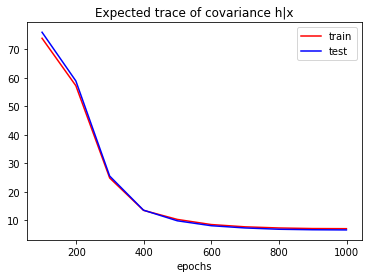

In [37]:
my_plot2(tr_cov_h_giv_x_train, tr_cov_h_giv_x_test, title = 'Expected trace of covariance h|x')

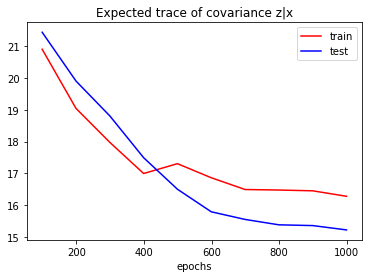

In [38]:
my_plot2(tr_cov_z_giv_x_train, tr_cov_z_giv_x_test, title = 'Expected trace of covariance z|x')

## Log det h|x, z|x

comparing between train and test <br>
log det of cov h|x, z|x are the same for both train/ test data

In [39]:
logdet_cov_h_giv_x_train, logdet_cov_z_giv_x_train = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [03:33<00:00, 21.37s/it]


In [40]:
logdet_cov_h_giv_x_test, logdet_cov_z_giv_x_test = Batch_x_to_value(X_test, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [03:32<00:00, 21.26s/it]


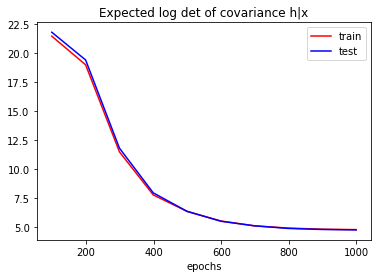

In [41]:
my_plot2(logdet_cov_h_giv_x_train, logdet_cov_h_giv_x_test, title = 'Expected log det of covariance h|x')

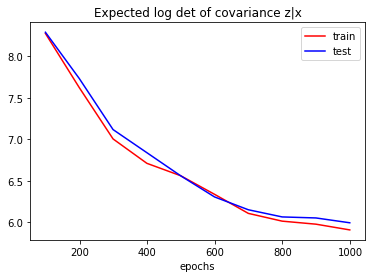

In [42]:
my_plot2(logdet_cov_z_giv_x_train, logdet_cov_z_giv_x_test, title = 'Expected log det of covariance z|x')

## Look at tr cov h, tr cov z

for h, z we use a batch of 300 pictures

In [43]:
X_train1 , X_test1 = gen_data_1pic(B = 300)

In [44]:
#Get trace
tr_cov_h_train, tr_cov_z_train = Batch_x_to_value(X_train1, checkpointfile, mode = 'trace')

100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


In [45]:
tr_cov_h_test, tr_cov_z_test = Batch_x_to_value(X_test1, checkpointfile, mode = 'trace')

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


comparing trace cov h, z between train/ test <br>
trace of cov h are the same for both train/ test but there are difference between train/ test in tr cov z. <br>
tr cov z for train set is higher than tr cov z for test set. <br>
Also, tr cov z for test set decreases as the epoch goes up while there is no evidence for the tr cov z for train set.

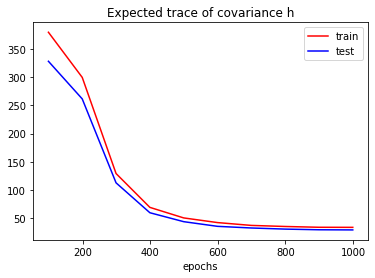

In [46]:
my_plot2(tr_cov_h_train, tr_cov_h_test, title = 'Expected trace of covariance h')

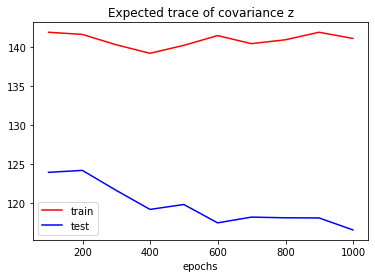

In [47]:
my_plot2(tr_cov_z_train, tr_cov_z_test, title = 'Expected trace of covariance z')

## log det cov h , cov z

log det cov h decreases for both train/ test set <br>
but log det cov z increases for both train/ test set

In [48]:
#Get log det
logdet_cov_h_train, logdet_cov_z_train = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


In [49]:
#Get log det
logdet_cov_h_test, logdet_cov_z_test = Batch_x_to_value(X_test1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


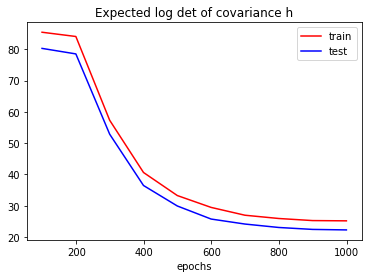

In [50]:
my_plot2(logdet_cov_h_train, logdet_cov_h_test, title = 'Expected log det of covariance h')

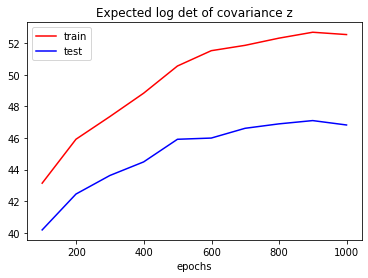

In [51]:
my_plot2(logdet_cov_z_train, logdet_cov_z_test, title = 'Expected log det of covariance z')

# Look at approximated mutual information I(X;Z)

I(X;Z) = H(Z) - H(Z|X)

In [78]:
def plot_diff(dict1,dict2, title = 'H(Z) - H(Z|X)', label1 = 'train'):
    A = list(dict1.values())
    B = list(dict2.values())
    A_B = [A[i]-B[i] for i in range(len(A))]
    my_plot(A_B, title = title, label1 = label1)

In [79]:
def plot_same_start(dict1,dict2, title = 'H(Z) - H(Z|X)', label1 = 'log det cov z', label2 = 'log det cov z|x'):
    A = list(dict1.values())
    B = list(dict2.values())
    A_tf = [A[i] - A[0] for i in range(len(A))]
    B_tf = [B[i] - B[0] for i in range(len(B))]
    plt.plot([99+ 100*i for i in range(10)], [A_tf[i] for i in range(10)], label = label1, color = 'r')
    plt.plot([99+ 100*i for i in range(10)], [B_tf[i] for i in range(10)], label = label2, color = 'b')
    plt.xlabel('epochs')
    plt.title(title)
    plt.legend()
    plt.show()

# log det cov z - log det cov z|x for train/ test

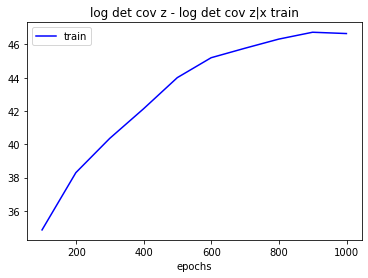

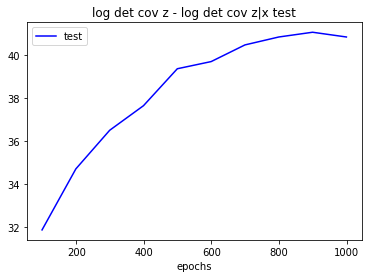

In [80]:
plot_diff(logdet_cov_z_train, logdet_cov_z_giv_x_train, title = 'log det cov z - log det cov z|x train', label1 = 'train')
plot_diff(logdet_cov_z_test, logdet_cov_z_giv_x_test, title = 'log det cov z - log det cov z|x test', label1 = 'test')

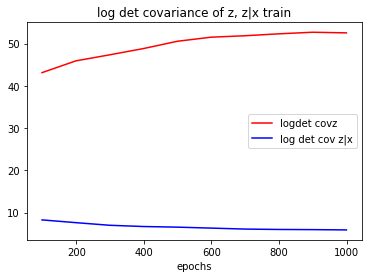

In [88]:
my_plot2(logdet_cov_z_train, logdet_cov_z_giv_x_train, label1 = 'logdet covz', label2 = 'log det cov z|x', title = 'log det covariance of z, z|x train')

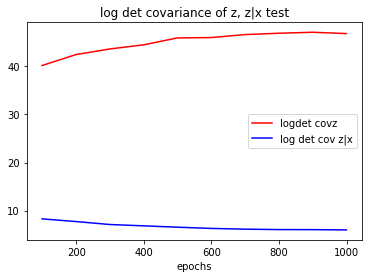

In [89]:
my_plot2(logdet_cov_z_test, logdet_cov_z_giv_x_test, label1 = 'logdet covz', label2 = 'log det cov z|x', title = 'log det covariance of z, z|x test')

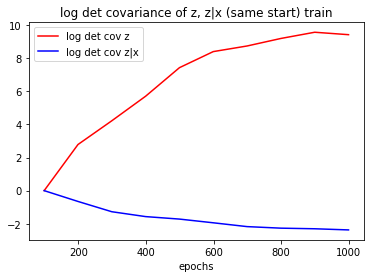

In [81]:
plot_same_start(logdet_cov_z_train, logdet_cov_z_giv_x_train, title = 'log det covariance of z, z|x (same start) train', label1 = 'log det cov z', label2 = 'log det cov z|x')

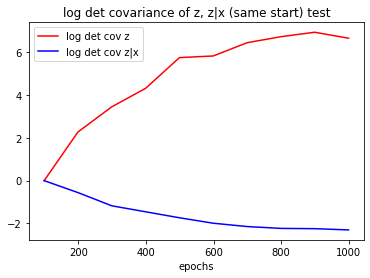

In [82]:
plot_same_start(logdet_cov_z_test, logdet_cov_z_giv_x_test, title = 'log det covariance of z, z|x (same start) test', label1 = 'log det cov z', label2 = 'log det cov z|x')

# log det cov h - log det cov h|x for train/ test

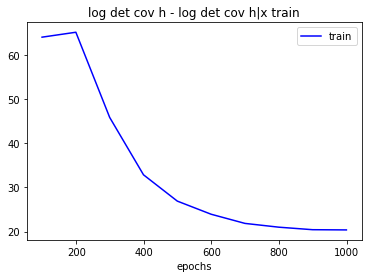

In [83]:
plot_diff(logdet_cov_h_train, logdet_cov_h_giv_x_train, title = 'log det cov h - log det cov h|x train')

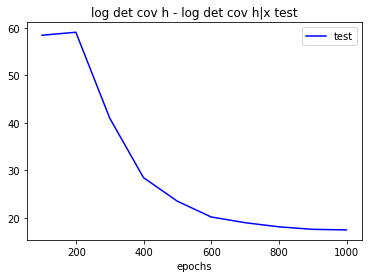

In [84]:
plot_diff(logdet_cov_h_test, logdet_cov_h_giv_x_test, title = 'log det cov h - log det cov h|x test', label1 = 'test')

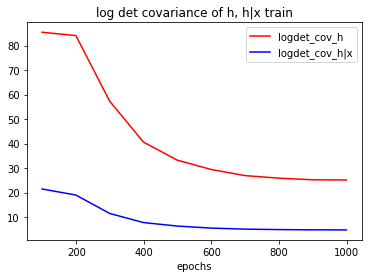

In [90]:
my_plot2(logdet_cov_h_train,logdet_cov_h_giv_x_train, label2 = 'logdet_cov_h|x', label1 = 'logdet_cov_h', title = 'log det covariance of h, h|x train')

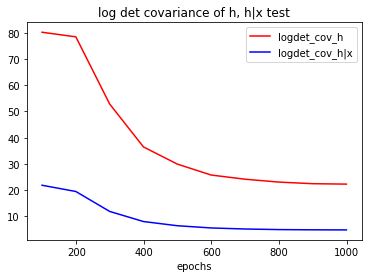

In [91]:
my_plot2(logdet_cov_h_test,logdet_cov_h_giv_x_test, label2 = 'logdet_cov_h|x', label1 = 'logdet_cov_h', title = 'log det covariance of h, h|x test')

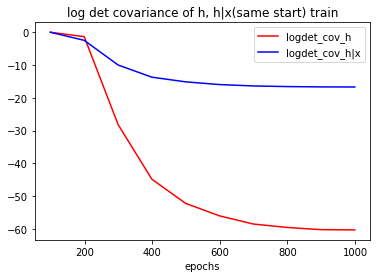

In [85]:
plot_same_start(logdet_cov_h_train, logdet_cov_h_giv_x_train, title = 'log det covariance of h, h|x(same start) train',
               label1 = 'logdet_cov_h', label2 = 'logdet_cov_h|x')

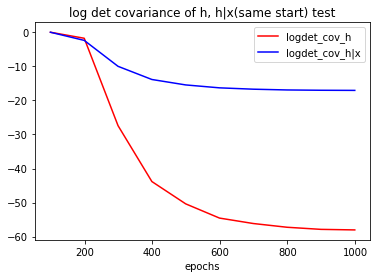

In [87]:
plot_same_start(logdet_cov_h_test, logdet_cov_h_giv_x_test, title = 'log det covariance of h, h|x(same start) test',
               label1 = 'logdet_cov_h', label2 = 'logdet_cov_h|x')

## Effect of chaning batch size

Change batch size B = 20,40,60,80 for log det h,z

In [60]:
X_train1 , X_test1 = gen_data_1pic(B = 20)
logdet_cov_h_train_20, logdet_cov_z_train_20 = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


In [61]:
X_train1 , X_test1 = gen_data_1pic(B = 40)
logdet_cov_h_train_40, logdet_cov_z_train_40 = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


In [62]:
X_train1 , X_test1 = gen_data_1pic(B = 60)
logdet_cov_h_train_60, logdet_cov_z_train_60 = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


In [63]:
X_train1 , X_test1 = gen_data_1pic(B = 80)
logdet_cov_h_train_80, logdet_cov_z_train_80 = Batch_x_to_value(X_train1, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


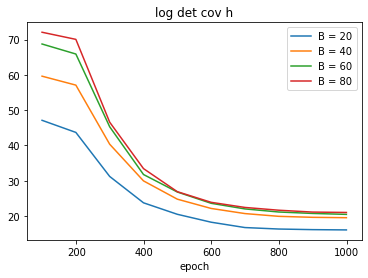

In [64]:
# estimated upper bound of the entropy depends on a batch size
A = [logdet_cov_h_train_20, logdet_cov_h_train_40, logdet_cov_h_train_60, logdet_cov_h_train_80]

for i in range(len(A)):
    result = A[i]
    plt.plot( [99+ 100*i for i in range(10)], list(result.values()), label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov h')
plt.show()

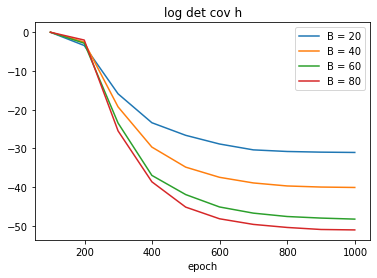

In [65]:
for i in range(len(A)):
    result = A[i]
    my_list = list(result.values())
    my_list_tf = [my_list[i] - my_list[0] for i in range(len(my_list))]
    plt.plot( [99+ 100*i for i in range(10)],my_list_tf, label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov h')
plt.show()

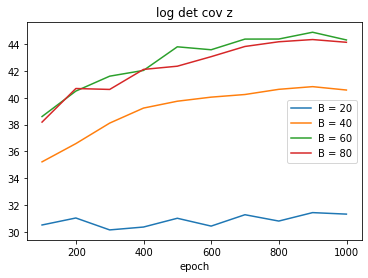

In [66]:
# estimated upper bound of the entropy depends on a batch size
A = [logdet_cov_z_train_20, logdet_cov_z_train_40, logdet_cov_z_train_60, logdet_cov_z_train_80]

for i in range(len(A)):
    result = A[i]
    plt.plot( [99+ 100*i for i in range(10)], list(result.values()), label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov z')
plt.show()

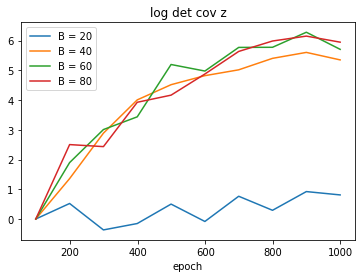

In [67]:
for i in range(len(A)):
    result = A[i]
    my_list = list(result.values())
    my_list_tf = [my_list[i] - my_list[0] for i in range(len(my_list))]
    plt.plot( [99+ 100*i for i in range(10)],my_list_tf, label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov z')
plt.show()

change batchsize B = 20,40,60,80 for h|x, z|x

In [68]:
#Gendata
X_train, X_test = gen_data(B=20, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
logdet_cov_h_giv_x_train20, logdet_cov_z_giv_x_train20 = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [01:21<00:00,  8.17s/it]


In [69]:
#Gendata
X_train, X_test = gen_data(B=40, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
logdet_cov_h_giv_x_train40, logdet_cov_z_giv_x_train40 = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [02:42<00:00, 16.27s/it]


In [70]:
#Gendata
X_train, X_test = gen_data(B=60, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
logdet_cov_h_giv_x_train60, logdet_cov_z_giv_x_train60 = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [04:02<00:00, 24.25s/it]


In [71]:
#Gendata
X_train, X_test = gen_data(B=80, sample = 100)
checkpointfile = ['resnet18_new.pth99']+ ['resnet18_new.pth' + str(i) + '99' for i in range(1,10)]
logdet_cov_h_giv_x_train80, logdet_cov_z_giv_x_train80 = Batch_x_to_value(X_train, checkpointfile, mode = 'log_det')

100%|██████████| 10/10 [05:22<00:00, 32.25s/it]


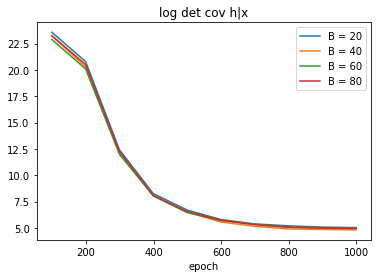

In [72]:
A = [logdet_cov_h_giv_x_train20, logdet_cov_h_giv_x_train40, logdet_cov_h_giv_x_train60, logdet_cov_h_giv_x_train80]

for i in range(len(A)):
    result = A[i]
    plt.plot( [99+ 100*i for i in range(10)], list(result.values()), label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov h|x')
plt.show()

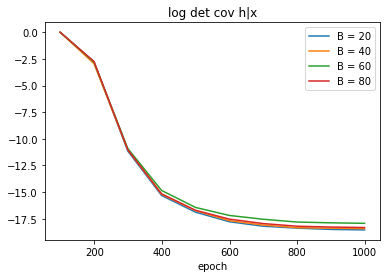

In [73]:
for i in range(len(A)):
    result = A[i]
    my_list = list(result.values())
    my_list_tf = [my_list[i] - my_list[0] for i in range(len(my_list))]
    plt.plot( [99+ 100*i for i in range(10)],my_list_tf, label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov h|x')
plt.show()

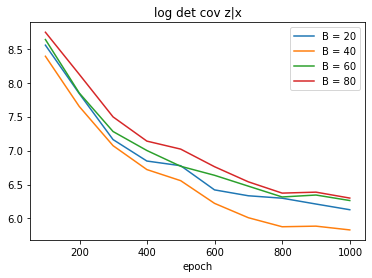

In [74]:
A = [logdet_cov_z_giv_x_train20, logdet_cov_z_giv_x_train40, logdet_cov_z_giv_x_train60, logdet_cov_z_giv_x_train80]

for i in range(len(A)):
    result = A[i]
    plt.plot( [99+ 100*i for i in range(10)], list(result.values()), label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov z|x')
plt.show()

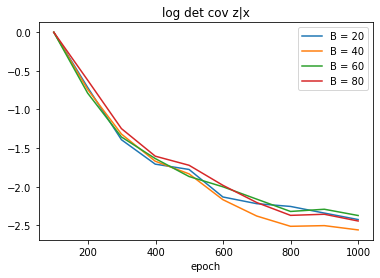

In [75]:
for i in range(len(A)):
    result = A[i]
    my_list = list(result.values())
    my_list_tf = [my_list[i] - my_list[0] for i in range(len(my_list))]
    plt.plot( [99+ 100*i for i in range(10)],my_list_tf, label = 'B = ' + str(20*(i+1)))
    plt.legend()
plt.xlabel('epoch')
plt.title('log det cov z|x')
plt.show()

# -----------------------END---------------------